### Pix2Pix GAN to generate recoloured images for protanopia diagnosis<br>
Date: Feb 2023- May 2023

In [1]:
from PIL import Image
import cv2
import os
import numpy as np
import pandas as pd
from numpy import zeros, ones, savez_compressed
from numpy.random import randint
from numpy import asarray, load, vstack
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv2DTranspose, Dropout, Conv2D, LeakyReLU
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model




#----------------------------------------------------------------------------------------------------------------------

def discriminator(image_shape):
    
    init= RandomNormal(stddev= 0.02)
    src_img= Input(shape= image_shape)
    trgt_img= Input(shape= image_shape)
    
    merged= Concatenate()([src_img,trgt_img])
    
    d= Conv2D(64, (4,4), strides= (2,2) ,padding= 'same', kernel_initializer= init)(merged)
    d= LeakyReLU(alpha=0.2)(d)
    
    d= Conv2D(128, (4,4), strides= (2,2), padding= 'same', kernel_initializer= init)(d)
    d= BatchNormalization()(d)
    d= LeakyReLU(alpha= 0.2)(d)
    
    d= Conv2D(256, (4,4), strides= (2,2), padding= 'same', kernel_initializer= init)(d)
    d= BatchNormalization()(d)
    d= LeakyReLU(alpha= 0.2)(d)
    
    d= Conv2D(512, (4,4), strides= (2,2), padding= 'same', kernel_initializer= init)(d)
    d= BatchNormalization()(d)
    d= LeakyReLU(alpha= 0.2)(d)
    
    d= Conv2D(512, (4,4), padding= 'same', kernel_initializer= init)(d)
    d= BatchNormalization()(d)
    d= LeakyReLU(alpha= 0.2)(d)
    
    d= Conv2D(1, (4,4), padding='same', kernel_initializer= init)(d)
    patch_out= Activation('sigmoid')(d)
    
    model= Model([src_img,trgt_img], patch_out)
    
    
    opt=Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss= 'binary_crossentropy', optimizer= opt, loss_weights= [0.5])
    
    return model

#----------------------------------------------------------------------------------------------------------------------

def encoder(layer_in, n_filters, batchnorm=True):
    
    init= RandomNormal(stddev= 0.02)
    
    g= Conv2D(n_filters, (4,4), strides= (2,2), padding= 'same', kernel_initializer= init)(layer_in)
    if batchnorm:
        g= BatchNormalization()(g, training= True)
    g= LeakyReLU(alpha= 0.2)(g)
    
    return g

#----------------------------------------------------------------------------------------------------------------------

def decoder(layer_in, skip_in, n_filters, dropout= True):
    
    init= RandomNormal(stddev= 0.02)
    
    g= Conv2DTranspose(n_filters, (4,4), strides= (2,2), padding= 'same', kernel_initializer= init)(layer_in)
    g= BatchNormalization()(g, training= True)
    if dropout:
        g= Dropout(0.5)(g, training= True)
    g= Concatenate()([g, skip_in])
    g= Activation('relu')(g)
    
    return g

#----------------------------------------------------------------------------------------------------------------------

def generator(image_shape= (256,256,3)):
    
    init= RandomNormal(stddev= 0.02)
    
    in_image= Input(shape= image_shape)
    
    e1= encoder(in_image, 64, batchnorm=False)
    e2= encoder(e1, 128)
    e3= encoder(e2, 256)
    e4= encoder(e3, 512)
    e5= encoder(e4, 512)
    e6= encoder(e5, 512)
    e7= encoder(e6, 512)
    
    b= Conv2D(512, (4,4), strides= (2,2), padding= 'same', kernel_initializer= init)(e7)
    b= Activation('relu')(b)
    
    d1= decoder(b, e7, 512)
    d2= decoder(d1, e6, 512)
    d3= decoder(d2, e5, 512)
    d4= decoder(d3, e4, 512, dropout= False)
    d5= decoder(d4, e3, 256, dropout= False)
    d6= decoder(d5, e2, 128, dropout= False)
    d7= decoder(d6, e1, 64, dropout= False)
    
    g= Conv2DTranspose(image_shape[2], (4,4), strides= (2,2), padding= 'same', kernel_initializer= init)(d7)
    out_image= Activation('tanh')(g)
    model= Model(in_image, out_image)
    
    return model

#----------------------------------------------------------------------------------------------------------------------

def gan(gen, disc, image_shape):
    
    for layer in disc.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable= False
            
    in_src= Input(shape= image_shape)
    gen_out= gen(in_src)
    dis_out= disc([in_src, gen_out])
    
    model= Model(in_src, [dis_out, gen_out])    
    opt= Adam(lr= 0.02, beta_1= 0.5)
    model.compile(loss= ['binary_crossentropy', 'mae'], optimizer= opt, loss_weights= [1,100])
    
    return model

#----------------------------------------------------------------------------------------------------------------------

def generate_real_samples(dataset, n_samples, patch_shape):
    
    trainA, trainB = dataset
    #out_images = [X_train[index] for index in indices]
    #ix = randint(0, asarray(trainA).shape[0], n_samples)
    ix = randint(0, trainA.shape[0], n_samples)
    #ix.shape
    #ix=asarray(a)
    x1,x2= trainA[ix],  trainB[ix] 
    #x1, x2= trainA[ix.astype(int)], trainB[ix.astype(int)]
    y= ones((n_samples, patch_shape, patch_shape, 1))
    
    return [x1,x2], y

#----------------------------------------------------------------------------------------------------------------------

def generate_fake_samples(g_model, samples, patch_shape):
    #print("Shape:",asarray(samples).shape)
    
    x= g_model.predict(samples)
    y= zeros((len(x), patch_shape, patch_shape, 1))
    
    return x, y

#----------------------------------------------------------------------------------------------------------------------

def summarize_performance(step, g_model, dataset, n_samples=3):
    
    [x_realA, x_realB], _= generate_real_samples(dataset, n_samples, 1)
    x_fakeB, _= generate_fake_samples(g_model, x_realA, 1)
    
    x_realA= (x_realA + 1) / 2.0
    x_realB= (x_realA + 1) / 2.0
    x_fakeB= (x_fakeB + 1) / 2.0
    
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(x_realA[i])
        
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(x_fakeB[i])
        
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(x_realB[i])
        
    filename= 'plot_%0gd.png' % (step + 1)
    plt.savefig(filename)
    plt.close
    
    filename2= 'model_%0gd.h5' % (step + 1)
    g_model.save(filename2)
    print('->Saved: %s and %s'%(filename, filename2))

#----------------------------------------------------------------------------------------------------------------------

def train(d_model, g_model, gan_model, dataset, n_epochs= 1, n_batch= 1):
    
    n_patch= d_model.output_shape[1]
    trainA, trainB= dataset
    bat_per_epo= int(len(trainA) / n_batch)
    n_steps= bat_per_epo * n_epochs
    d1, d2, g= [], [], []
    for i in range(n_steps):
        [x_realA, x_realB], y_real= generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake= generate_fake_samples(g_model, x_realA, n_patch)
#         print(asarray(x_realA).shape, asarray(x_realB).shape, np.unique(asarray(y_real)))
#         print(asarray(X_fakeB).shape, asarray(y_fake).shape)
        d_loss1= d_model.train_on_batch([asarray(x_realA), asarray(x_realB)], asarray(y_real))
        d_loss2= d_model.train_on_batch([asarray(x_realA), asarray(X_fakeB)], asarray(y_fake))
        g_loss, _, _= gan_model.train_on_batch(asarray(x_realA), [asarray(y_real), asarray(x_realB)])
        
        print('->%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        d1.append(d_loss1)
        d2.append(d_loss2)
        g.append(g_loss)
        
        if(i + 1) % (bat_per_epo * 0.1) == 0:
            summarize_performance(i, g_model, dataset)
    
    
    return [d1, d2, g]

#----------------------------------------------------------------------------------------------------------------------

def load_images(path):
    
    original= os.listdir('/kaggle/input/redimage/original/original')
    daltonized= os.listdir('/kaggle/input/redimage/daltonized/daltonized')
    src_images, tar_images= list(), list()
    for i,name in enumerate (original):
        if i>=2600:
            break
        image=cv2.imread(path+'/original/original/'+name)
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(imageRGB,mode='RGB')
        image=Image.fromarray(imageRGB)        
        image=image.resize((256,256))
        src_images.append(np.array(image))
            
    for i,name in enumerate(daltonized):
        if i>=2600:
            break
        image=cv2.imread(path+'/daltonized/daltonized/'+name)
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(imageRGB,mode='RGB')
        image=Image.fromarray(imageRGB)
        image=image.resize((256,256))
        tar_images.append(np.array(image))
    
    return [asarray(src_images), asarray(tar_images)]

#----------------------------------------------------------------------------------------------------------------------



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Loaded: (2600, 256, 256, 3) (2600, 256, 256, 3)


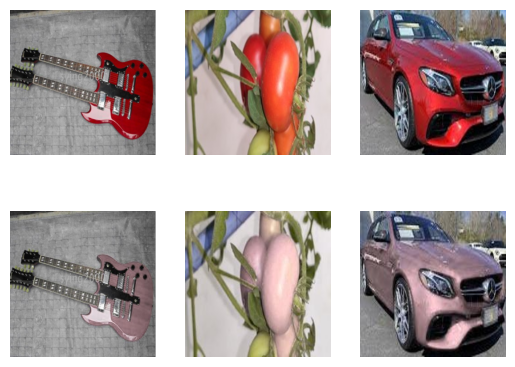

In [2]:
path= '/kaggle/input/redimage'

[src_images, tar_images]= load_images(path)
print('Loaded:', asarray(src_images).shape, asarray(tar_images).shape)

n_samples= 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))

    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples+ i)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
plt.show()


In [3]:
def preprocess(data):
    x1,x2= asarray(data[0]),asarray(data[1])
    x1= (x1 - 127.5)/127.5
    x2= (x2 - 127.5)/127.5
    return [x1,x2]

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-06-14 10:44:25.974308: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 6s 6s/step


2023-06-14 10:44:40.634937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


->1, d1[0.474] d2[2.912] g[44.277]
1/1 [==============================] - 0s 22ms/step
->2, d1[1.656] d2[3.467] g[31.288]
1/1 [==============================] - 0s 21ms/step
->3, d1[0.609] d2[1.289] g[33.212]
1/1 [==============================] - 0s 24ms/step
->4, d1[0.442] d2[0.695] g[47.052]
1/1 [==============================] - 0s 21ms/step
->5, d1[0.414] d2[0.545] g[41.149]
1/1 [==============================] - 0s 23ms/step
->6, d1[0.544] d2[0.439] g[62.224]
1/1 [==============================] - 0s 21ms/step
->7, d1[0.514] d2[0.442] g[52.464]
1/1 [==============================] - 0s 32ms/step
->8, d1[0.493] d2[0.515] g[16.083]
1/1 [==============================] - 0s 21ms/step
->9, d1[0.441] d2[0.457] g[16.015]
1/1 [==============================] - 0s 21ms/step
->10, d1[0.464] d2[0.446] g[22.680]
1/1 [==============================] - 0s 21ms/step
->11, d1[0.456] d2[0.496] g[16.692]
1/1 [==============================] - 0s 21ms/step
->12, d1[0.435] d2[0.466] g[32.168]
1/1 [

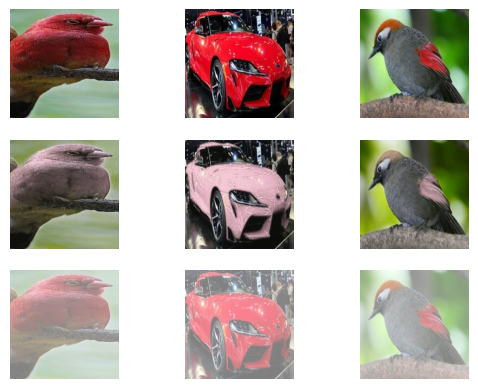

In [4]:
image_shape= asarray(src_images).shape[1:]


d_model=discriminator(image_shape)
g_model=generator(image_shape)
gan_model= gan(g_model, d_model, image_shape)

data=[src_images, tar_images]

dataset=preprocess(data)

from datetime import datetime
start1= datetime.now()

d1, d2, g= train(d_model, g_model, gan_model, dataset, n_epochs= 1, n_batch= 1)

stop1= datetime.now()

executiontime= stop1 - start1
print("Execution time is:", executiontime)

Text(0, 0.5, 'steps')

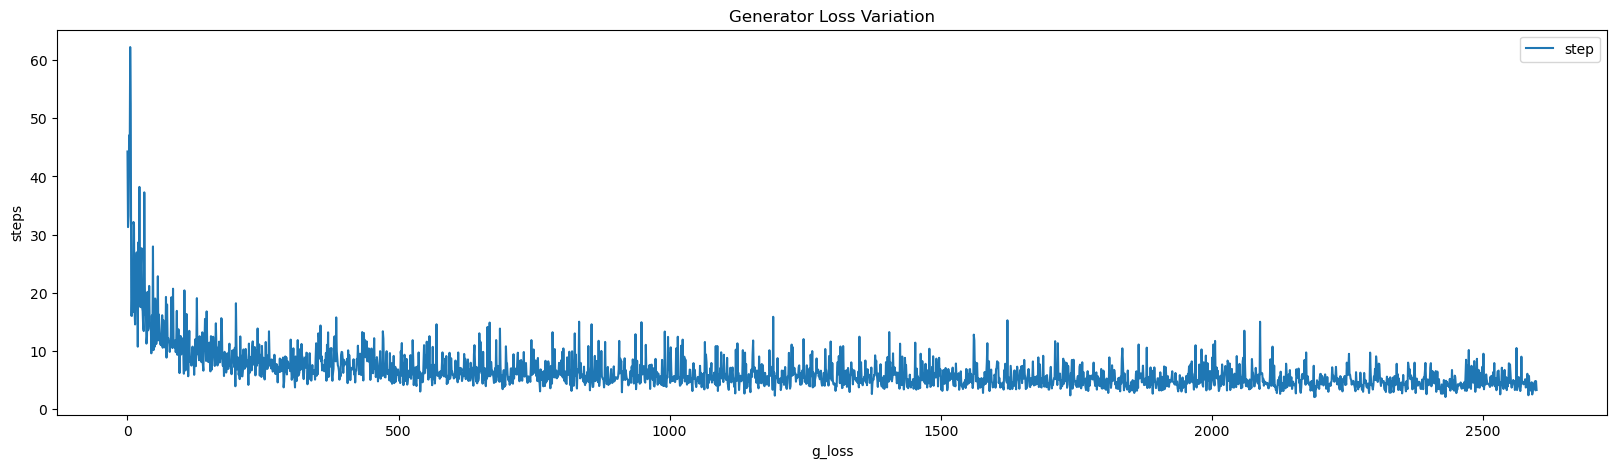

In [5]:
x=[]
for i in range(2601):
    x.append(i)

df= pd.DataFrame(list(zip(x,g)),columns =['g_loss', 'step'])
df.plot('g_loss', 'step', title='Generator Loss Variation', figsize=(20, 5))
plt.ylabel('steps')

Text(0, 0.5, 'loss')

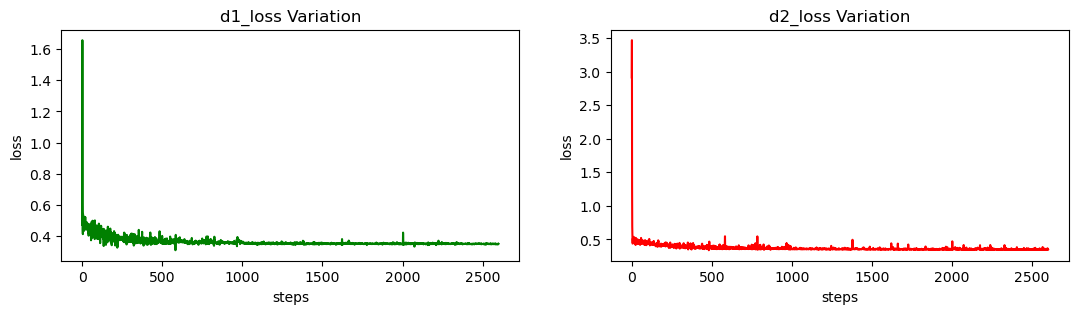

In [6]:
plt.figure(figsize=(13,3))

title=['d1_loss Variation', 'd2_loss Variation']
plt.subplot(1, 2, 1)
plt.plot(d1, 'g')
plt.title(title[0])
plt.xlabel('steps')
plt.ylabel('loss')

plt.subplot(1, 2, 2 )
plt.plot(d2, 'r')
plt.title(title[1])
plt.xlabel('steps')
plt.ylabel('loss')

In [7]:
def plot_images(src_img, gen_img, tar_img):
    
    images= vstack((src_img, gen_img, tar_img))
    images= (images+1)/2.0
    titles=['Source','Generated', 'Expected']
    
    for i in range(len(images)):
        
        plt.subplot(1,3,1+i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

    

In [8]:
def mse(img1, img2):
   diff = img1 - img2
   err = np.sum(diff**2)
   mse = err/(float(256*256))
   return mse

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 509ms/step


2023-06-14 10:52:15.649596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  260 



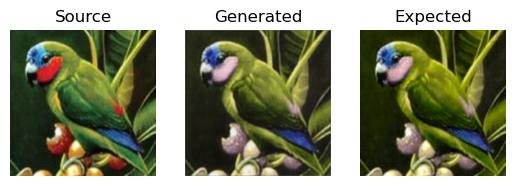

Error :-  0.0384403586979426 

1/1 [==============================] - 0s 395ms/step


2023-06-14 10:52:18.366888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  520 



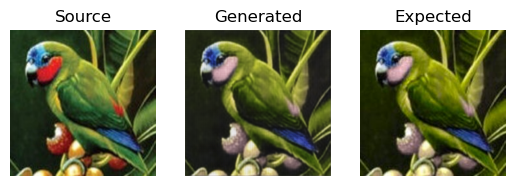

Error :-  0.023646869383522708 

1/1 [==============================] - 0s 395ms/step


2023-06-14 10:52:21.033440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  780 



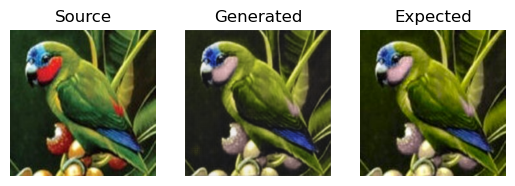

Error :-  0.02462061711257211 

1/1 [==============================] - 0s 402ms/step


2023-06-14 10:52:23.713487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  1040 



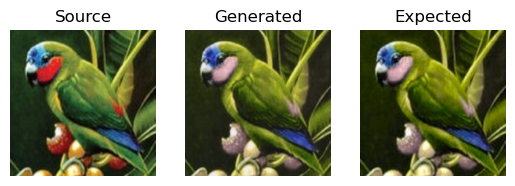

Error :-  0.01763973257446347 

1/1 [==============================] - 0s 388ms/step


2023-06-14 10:52:26.554567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  1300 



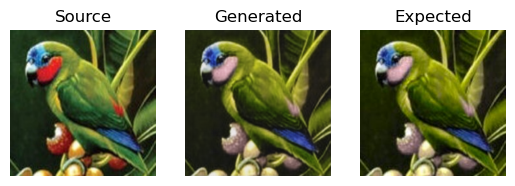

Error :-  0.012745364233753513 

1/1 [==============================] - 0s 387ms/step


2023-06-14 10:52:29.277138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  1560 



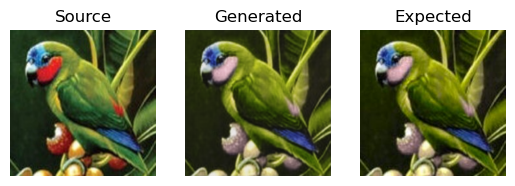

Error :-  0.010614839782833996 

1/1 [==============================] - 0s 393ms/step


2023-06-14 10:52:31.832192: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  1820 



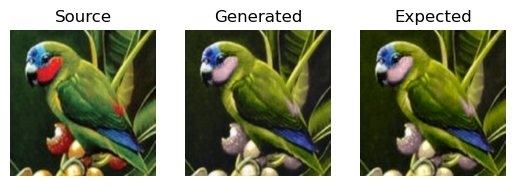

Error :-  0.012753327941979843 

1/1 [==============================] - 0s 391ms/step


2023-06-14 10:52:34.278607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  2080 



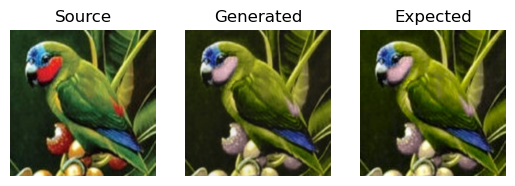

Error :-  0.008303184721352965 

1/1 [==============================] - 0s 466ms/step


2023-06-14 10:52:37.387725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  2340 



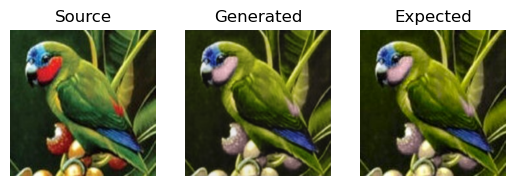

Error :-  0.007012152203950042 

1/1 [==============================] - 0s 408ms/step


2023-06-14 10:52:39.823297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


After  2600 



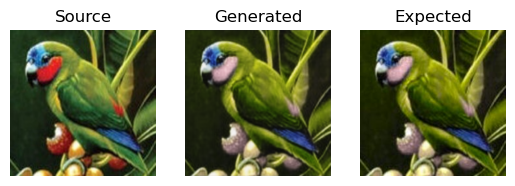

Error :-  0.0068804819544133825 



In [9]:
error=list()
for i in range(1,11):
    model= load_model(f'model_{26*i*10 }d.h5',compile=False)
    [x1,x2]= dataset
    ix=randint(7,8,1)
    src_image, tar_image= x1[ix], x2[ix]
    gen_image= model.predict(src_image)
    print("After ",26*i*10,"\n")
    plot_images(src_image, gen_image, tar_image)
    erval=mse(gen_image,tar_image)
    print("Error :- ",erval,"\n")
    error.append(erval)

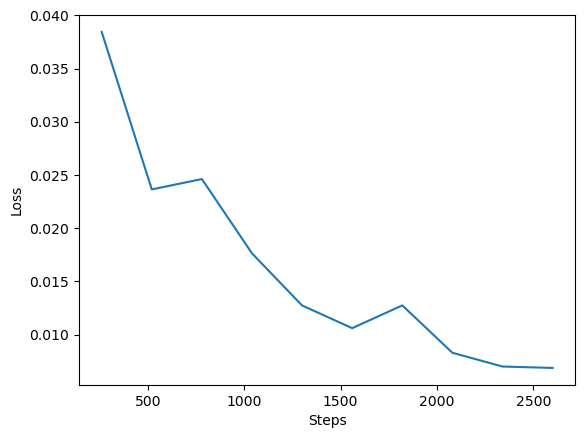

In [10]:
x,y=list(),list()
i=0
for j in (error):
    y.append(j)
    x.append(i+260)
    i=i+260
plt.xlabel("Steps")
plt.ylabel("Loss") 
plt.plot(x,y)

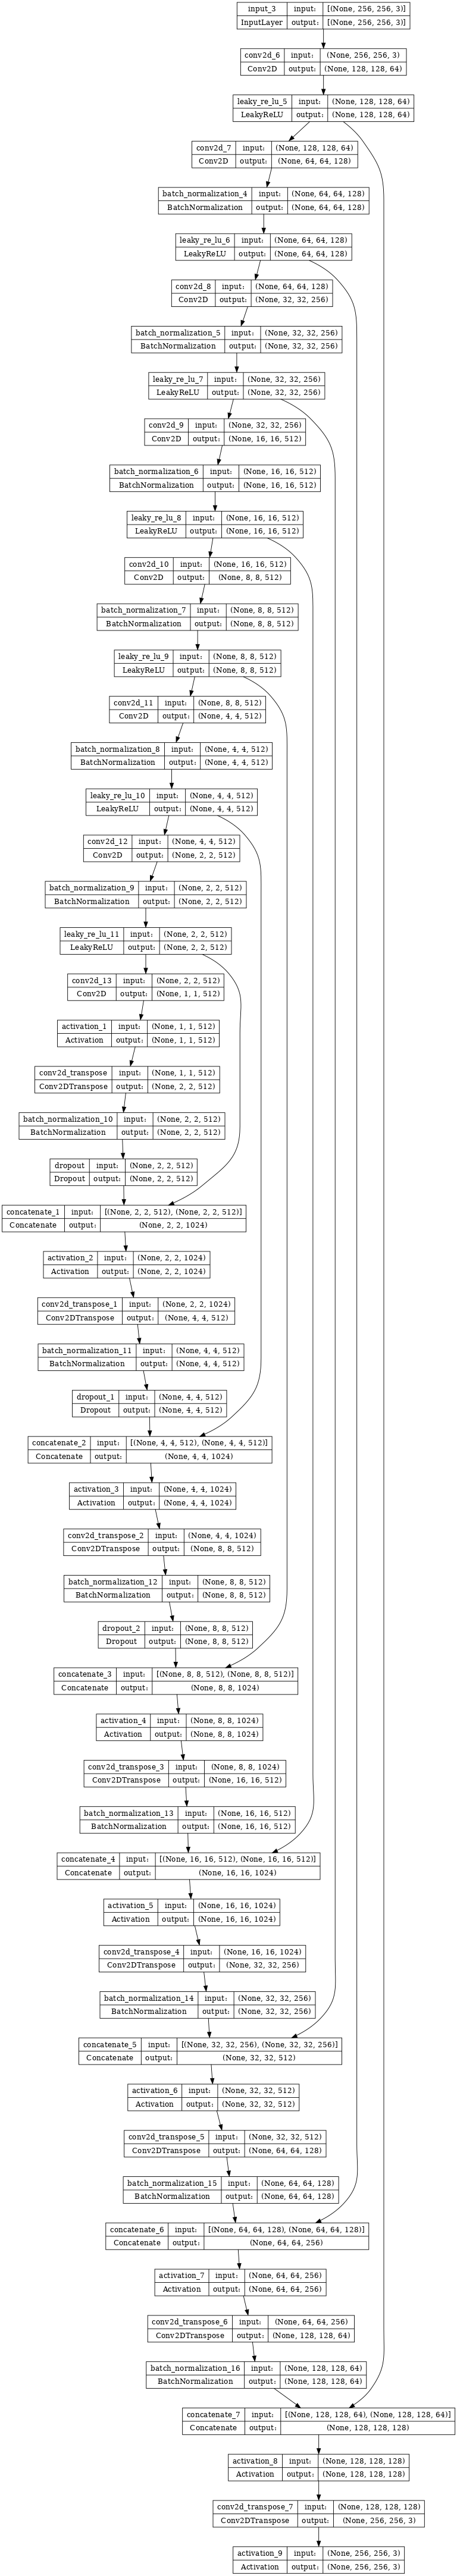

In [11]:
plot_model(g_model, show_shapes=True, dpi=64)

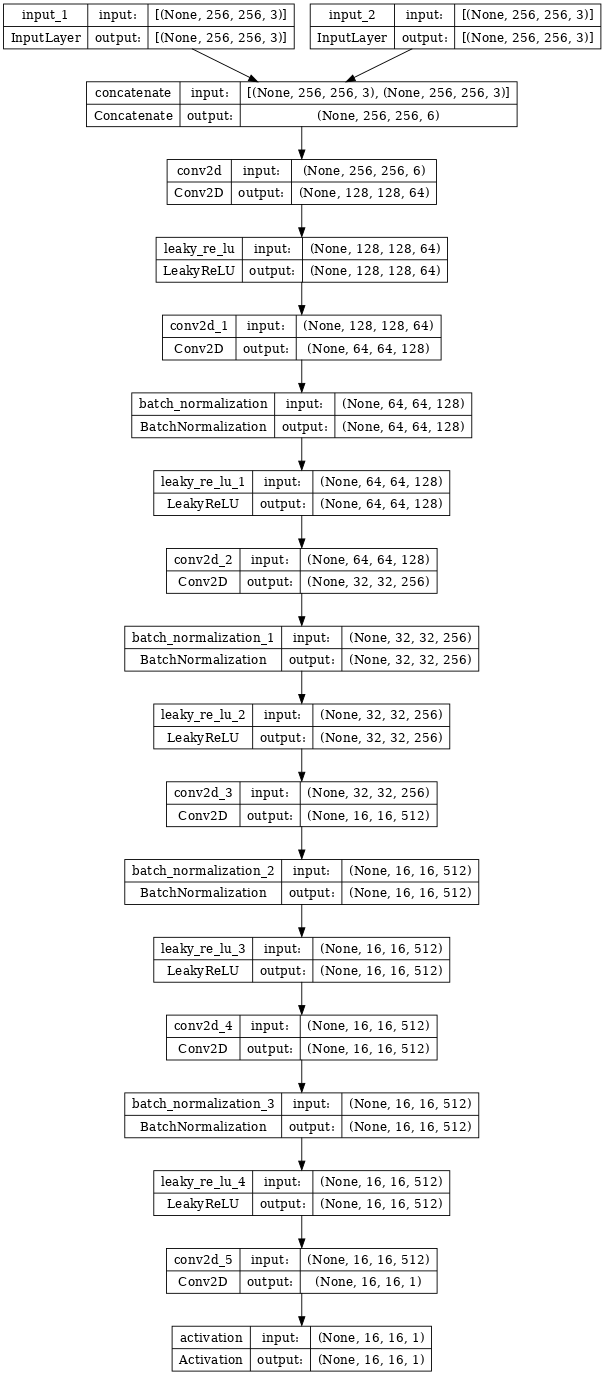

In [12]:
plot_model(d_model, show_shapes=True, dpi=64)